### 1. Laboratorio clase 3: Introducción y contexto

En este laboratorio vamos a profundizar en la construcción de modelos N-gram, modelos de Markov ocultos, y en los principios de funcionamiento de redes neuronales en el contexto del procesamiento del lenguaje natural. El objetivo de estos ejercicios es aprende a construir modelos de lengiaje simples con los que podamos llevar a cabo tareas como completar prompts, asignarle tags a palabras y entrenar embedding para palabras usando redes neuronales.

### 2. Modelos N-gram

En este ejercicio, vamos a construir modelos N-gram para completar texto. Para construir los modelos, vamos a permitir cambiar N para ver el desempeño del modelo con diferentes configuraciones. Adicionalmente, calcularemos las probabilidades que el modelo predice con suavizado de Laplace con el fin de mejorar el desempeño del modelo. 

In [34]:
# Importamos las librerías necesarias
import os
import shutil
local_nltk_path = os.path.join(os.getcwd(), "nltk_data")
shutil.rmtree(local_nltk_path, ignore_errors=True)
os.makedirs(local_nltk_path, exist_ok=True)
import nltk
nltk.data.path.clear()
nltk.data.path.append(local_nltk_path)
nltk.download('punkt', download_dir=local_nltk_path)
nltk.download('punkt_tab', download_dir=local_nltk_path)
nltk.download('perluniprops', download_dir=local_nltk_path)
nltk.download('nonbreaking_prefixes', download_dir=local_nltk_path)
from collections import Counter
import math
import unicodedata
import string

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


In [ ]:
# Definimos el corpus de texto en español para entrenar el modelo. Además, procesamos el texto para eliminar acentos y normalizarlo.

corpus = """
El gato se sentó en la alfombra. El perro se sentó en el tronco. El gato y el perro son amigos.
María tiene un gato llamado Tomás que le gusta dormir en la alfombra.
Los perros generalmente prefieren los espacios abiertos como los parques.
Ana y Juan pasean a sus perros todas las mañanas antes del desayuno.
El clima estaba soleado y los niños jugaban con sus mascotas en el jardín.
Un gato curioso se subió al tejado y observó todo desde arriba.
La tienda de mascotas vende comida, juguetes y ropa para perros y gatos.
"""

def normalize_text(text, remove_punctuation=False):
    """
    Normaliza el texto eliminando acentos y, opcionalmente, signos de puntuación.

    Args:
        text (str): Texto de entrada a normalizar.
        remove_punctuation (bool): Si es True, elimina la puntuación.

    Returns:
        str: Texto normalizado.
    """
    text = ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    return text


cleaned_corpus = normalize_text(corpus, remove_punctuation=False)
tokens = nltk.word_tokenize(cleaned_corpus.lower(), language='spanish')
vocab = set(tokens)

In [ ]:
# Generamos N-gramas y calculamos probabilidades suavizadas.

def generate_ngrams(tokens, N):
    """
    Genera una lista de N-gramas a partir de una lista de tokens.

    Args:
        tokens (list): Lista de tokens (palabras).
        N (int): Tamaño del N-grama.

    Returns:
        list: Lista de tuplas, cada una representando un N-grama.
    """
    return [tuple(tokens[i:i+N]) for i in range(len(tokens)-N+1)]

N = 1
grams = generate_ngrams(tokens, N)
ngram_freq = Counter(grams)
prefix_freq = Counter([gram[:-1] for gram in grams])

def ngram_prob_smoothed(prefix, word, alpha=0.3):
    """
    Calcula la probabilidad suavizada (Laplace) de que una palabra siga a un prefijo dado.

    Args:
        prefix (tuple or list): Prefijo de palabras (N-1 palabras).
        word (str): Palabra candidata a seguir el prefijo.
        alpha (float): Parámetro de suavizado.

    Returns:
        float: Probabilidad suavizada de la palabra dada el prefijo.
    """
    prefix = tuple(prefix)
    return (ngram_freq[prefix + (word,)] + alpha) / (prefix_freq[prefix] + alpha * len(vocab))

In [ ]:
# Predicción de la siguiente palabra

def predict_next_ngram(context):
    """
    Predice la siguiente palabra más probable dado un contexto usando el modelo N-grama suavizado.

    Args:
        context (list): Lista de palabras previas (contexto).

    Returns:
        str: Palabra más probable como siguiente en el contexto.
    """
    context = context[-(N-1):]  # ensure correct context length
    candidates = {w: ngram_prob_smoothed(context, w) for w in vocab}
    return max(candidates, key=candidates.get)

print(f"Palabra luego de ['el', 'gato']: {predict_next_ngram(['el', 'gato'])}")

Palabra luego de ['el', ' ']: dormir


### 3. POS usando modelos de Markov ocultos

Most likely POS tags: ['Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion']
POS Prediction for new sentence:
[('el', 'Articulo'), ('gato', 'Sustantivo'), ('juega', 'Verbo'), ('.', 'Puntuacion')]


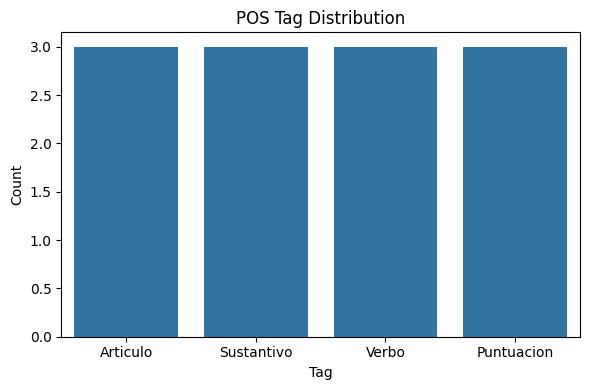

[Optional] To compare with SpaCy, install it and run: python -m spacy download es_core_news_sm


In [33]:
tagged_obs = [
    ('el', 'Articulo'), ('gato', 'Sustantivo'), ('duerme', 'Verbo'), ('.', 'Puntuacion'),
    ('la', 'Articulo'), ('niña', 'Sustantivo'), ('juega', 'Verbo'), ('.', 'Puntuacion'),
    ('el', 'Articulo'), ('perro', 'Sustantivo'), ('ladra', 'Verbo'), ('.', 'Puntuacion')
]
from collections import Counter, defaultdict

# 1. Observations and states
observations = [w for w, _ in tagged_obs]
tags = [t for _, t in tagged_obs]
states = sorted(set(tags))

# 2. Compute start_prob (which tag starts a sentence?)
# We'll assume new sentences start at positions: 0, 4, 8
start_positions = [0, 4, 8]
start_counts = Counter([tags[i] for i in start_positions])
start_prob = {tag: start_counts[tag] / len(start_positions) for tag in states}

# 3. Compute trans_prob (P(tag_i | tag_{i-1}))
transitions = list(zip(tags[:-1], tags[1:]))
trans_counts = Counter(transitions)
prev_tag_counts = Counter(tags[:-1])
trans_prob = {
    tag1: {
        tag2: trans_counts[(tag1, tag2)] / prev_tag_counts[tag1]
        for tag2 in states if (tag1, tag2) in trans_counts
    }
    for tag1 in states
}

# 4. Compute emiss_prob (P(word | tag))
emit_counts = defaultdict(Counter)
for word, tag in tagged_obs:
    emit_counts[tag][word] += 1

emiss_prob = {
    tag: {
        word: count / sum(emit_counts[tag].values())
        for word, count in emit_counts[tag].items()
    }
    for tag in states
}


def viterbi(obs, states, start_p, trans_p, emit_p):
    """
    Implementa el algoritmo de Viterbi para encontrar la secuencia de etiquetas más probable en un modelo HMM.

    Args:
        obs (list): Secuencia de observaciones (palabras).
        states (list): Lista de posibles estados (etiquetas).
        start_p (dict): Probabilidades iniciales de los estados.
        trans_p (dict): Probabilidades de transición entre estados.
        emit_p (dict): Probabilidades de emisión de observaciones dado el estado.

    Returns:
        tuple: (probabilidad total, lista de etiquetas más probables)
    """
    V = [{}]
    path = {}
    for s in states:
        start_prob_safe = start_p.get(s, 1e-6)
        emit_prob_safe = emit_p.get(s, {}).get(obs[0], 1e-6)
        V[0][s] = math.log(max(start_prob_safe, 1e-6)) + math.log(max(emit_prob_safe, 1e-6))
        path[s] = [s]

    for t in range(1, len(obs)):
        V.append({})
        new_path = {}
        for curr in states:
            (prob, prev) = max(
                (
                    V[t - 1][s] + math.log(trans_p[s].get(curr, 1e-6)) + math.log(emit_p[curr].get(obs[t], 1e-6)),
                    s
                ) for s in states
            )
            V[t][curr] = prob
            new_path[curr] = path[prev] + [curr]
        path = new_path

    (prob, final_state) = max((V[-1][s], s) for s in states)
    return math.exp(prob), path[final_state]

prob, tags = viterbi(observations, states, start_prob, trans_prob, emiss_prob)
print("Most likely POS tags:", tags)

def predict_pos(sentence):
    """
    Predice la secuencia de etiquetas gramaticales (POS) para una oración dada usando un modelo HMM.

    Args:
        sentence (str): Oración de entrada.

    Returns:
        list: Lista de tuplas (palabra, etiqueta).
    """
    tokens = nltk.word_tokenize(sentence.lower(), language='spanish')
    prob, tags = viterbi(tokens, states, start_prob, trans_prob, emiss_prob)
    return list(zip(tokens, tags))

# Example usage
new_sentence = "el gato juega ."
print("POS Prediction for new sentence:")
print(predict_pos(new_sentence))

# Follow-up exercise: visualize tag distribution
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pos_counts = Counter(tags)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()))
plt.title("POS Tag Distribution")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Optional: Compare with SpaCy POS tagging if installed
try:
    import spacy
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(" ".join(observations))
    spacy_tags = [token.pos_ for token in doc if token.text in observations]

    # Align HMM tags and SpaCy tags
    common_len = min(len(spacy_tags), len(tags))
    aligned_spacy = spacy_tags[:common_len]
    aligned_hmm = tags[:common_len]

    # Display confusion matrix
    cm = confusion_matrix(aligned_spacy, aligned_hmm, labels=list(set(aligned_spacy + aligned_hmm)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(aligned_spacy + aligned_hmm)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix: SpaCy vs HMM")
    plt.tight_layout()
    plt.show()
except:
    print("[Optional] To compare with SpaCy, install it and run: python -m spacy download es_core_news_sm")

### 3. Embeddings con CBOW

In [4]:
import numpy as np

def sigmoid(x):
    """
    Calcula la función de activación sigmoide.

    Args:
        x (float or np.ndarray): Valor de entrada.

    Returns:
        float or np.ndarray: Valor transformado por la función sigmoide.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    Calcula la derivada de la función sigmoide.

    Args:
        x (float or np.ndarray): Valor de entrada.

    Returns:
        float or np.ndarray: Derivada de la función sigmoide.
    """
    return x * (1 - x)

# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

np.random.seed(1)
W1 = 2 * np.random.random((2, 4)) - 1
W2 = 2 * np.random.random((4, 1)) - 1

# Training loop with learning rate
lr = 0.1
for epoch in range(10000):
    # Forward pass
    L1 = sigmoid(np.dot(X, W1))
    L2 = sigmoid(np.dot(L1, W2))

    # Backpropagation
    error = y - L2
    delta2 = error * sigmoid_derivative(L2)
    delta1 = delta2.dot(W2.T) * sigmoid_derivative(L1)

    # Update weights
    W2 += lr * L1.T.dot(delta2)
    W1 += lr * X.T.dot(delta1)

print("Predictions after training:", sigmoid(np.dot(sigmoid(np.dot(X, W1)), W2)))

Predictions after training: [[0.09581334]
 [0.91580613]
 [0.91080945]
 [0.09593608]]


In [5]:
# --- 4. CBOW MODEL ---

import torch
import torch.nn as nn
import torch.optim as optim

text = "Estamos aprendiendo sobre el modelo cbow y las redes neuronales"
words = text.lower().split()
vocab = list(set(words))
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

# CBOW context window size = 1
data = []
for i in range(1, len(words) - 1):
    context = [words[i - 1], words[i + 1]]
    target = words[i]
    data.append((context, target))

class CBOW(nn.Module):
    """
    Implementa el modelo Continuous Bag of Words (CBOW) usando PyTorch para aprender embeddings de palabras.

    Args:
        vocab_size (int): Tamaño del vocabulario.
        embed_dim (int): Dimensión de los embeddings.
    """
    def __init__(self, vocab_size, embed_dim):
        """
        Inicializa las capas del modelo CBOW.

        Args:
            vocab_size (int): Tamaño del vocabulario.
            embed_dim (int): Dimensión de los embeddings.
        """
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_idxs):
        """
        Realiza la pasada hacia adelante del modelo CBOW.

        Args:
            context_idxs (torch.Tensor): Índices de las palabras de contexto.

        Returns:
            torch.Tensor: Predicción de la palabra objetivo.
        """
        embeds = self.embeddings(context_idxs)
        context_vec = embeds.mean(dim=0)
        out = self.linear(context_vec)
        return out

model = CBOW(len(vocab), 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train
for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long)

        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_fn(log_probs.view(1, -1), target_idx)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Show learned embeddings
print("Word embeddings for 'cbow':", model.embeddings.weight[word_to_ix['cbow']])

Epoch 0, Loss: 19.3960
Epoch 20, Loss: 12.0407
Epoch 40, Loss: 8.0762
Epoch 60, Loss: 5.7105
Epoch 80, Loss: 4.2228
Word embeddings for 'cbow': tensor([ 0.4481, -0.0372, -1.1773, -0.3090, -1.1149, -1.0595,  0.2916, -0.3403,
        -0.5832, -3.0561], grad_fn=<SelectBackward0>)
